### Data Collection & Cleaning 

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [12]:
ny_df = pd.read_csv('./data/NY/newyork.csv')
ny_df.head()

,Release Year,County of Indictment,Gender,Age at Release,Return Status
0,2008,UNKNOWN,MALE,55,Not Returned
1,2008,ALBANY,MALE,16,Returned Parole Violation
2,2008,ALBANY,MALE,17,Not Returned
3,2008,ALBANY,MALE,17,Returned Parole Violation
4,2008,ALBANY,MALE,18,Not Returned


In [18]:
#Quick overview of the data shows 188k observations with only a few features including release year, county of indictment, age at release and gender. Return Status will be the target.
ny_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188650 entries, 0 to 188649
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Release Year          188650 non-null  int64 
 1   County of Indictment  188650 non-null  object
 2   Gender                188650 non-null  object
 3   Age at Release        188650 non-null  int64 
 4   Return Status         188650 non-null  object
dtypes: int64(2), object(3)
memory usage: 7.2+ MB


In [17]:
#Data is fairly clean no null values
ny_df.isnull().sum()

Release Year            0
County of Indictment    0
Gender                  0
Age at Release          0
Return Status           0
dtype: int64

In [16]:
#Based on a quick review of the stats we can see the average ages and distribution of ages at release which mainly range between 26 and 44 years old.
#We can also see the data spans release years between 2008 and 2015
ny_df.describe()

,Release Year,Age at Release
count,188650.000000,188650.000000
mean,2011.326064,35.473400
std,2.289170,10.972873
min,2008.000000,16.000000
25%,2009.000000,26.000000
50%,2011.000000,34.000000
75%,2013.000000,44.000000
max,2015.000000,100.000000


In [19]:
ny_df['Return Status'].value_counts(normalize = True)

Not Returned                 0.583106
Returned Parole Violation    0.325370
New Felony Offense           0.091524
Name: Return Status, dtype: float64

In [7]:
ny_df['Gender'].value_counts(normalize = True)

MALE      0.937228
FEMALE    0.062772
Name: Gender, dtype: float64

In [20]:
#Transforming the target variable 'Return Status' into 1s and 0s. 1 representing someone who returned to prison within 3 years of release and 0 representing someone who did not. 
ny_df['recidivism'] = ny_df['Return Status'].map({'Not Returned': 0, 'Returned Parole Violation' : 1, 'New Felony Offense' : 1})

In [21]:
#Transforming the Gender into 1s and 0s so it can be used in modeling. 1s represent Male 0s Female.
ny_df['gender_map'] = ny_df['Gender'].map({'MALE': 1, 'FEMALE': 0})
ny_df.head()

,Release Year,County of Indictment,Gender,Age at Release,Return Status,recidivism,gender_map
0,2008,UNKNOWN,MALE,55,Not Returned,0,1
1,2008,ALBANY,MALE,16,Returned Parole Violation,1,1
2,2008,ALBANY,MALE,17,Not Returned,0,1
3,2008,ALBANY,MALE,17,Returned Parole Violation,1,1
4,2008,ALBANY,MALE,18,Not Returned,0,1


### Exploratory Data Analysis

In [25]:
#Normalized Value counts across returned status. 58% did not return to prison, 32.5% returned due to parole violation and only 9% returned because of a new felony offense.
ny_df['Return Status'].value_counts(normalize = True)

Not Returned                 0.583106
Returned Parole Violation    0.325370
New Felony Offense           0.091524
Name: Return Status, dtype: float64

In [24]:
#The Majority Class which is non-recidivism represents 58% of the observations which will serve as the baseline for model accuracy
ny_df['recidivism'].value_counts(normalize = True)

0    0.583106
1    0.416894
Name: recidivism, dtype: float64

#### Age at Release

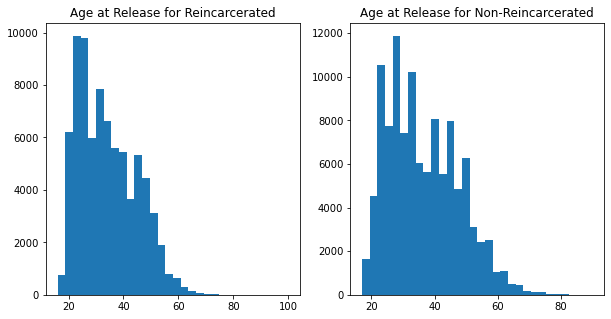

In [35]:
#Distribution of the Age at Release is pretty similar between those who are reincarcerated and those who are not with reincarcerated trending slightly lower in age.
fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].hist(ny_df[ny_df['recidivism'] == 1]['Age at Release'], bins = 30)
ax[0].set_title('Age at Release for Reincarcerated')
ax[1].hist(ny_df[ny_df['recidivism'] == 0]['Age at Release'], bins = 30)
ax[1].set_title('Age at Release for Non-Reincarcerated');

In [38]:
#split the dataset into different age ranges below 30, 30-50, 50 and above
below30 = ny_df[ny_df['Age at Release'] < 30]
between_30_50 = ny_df[(ny_df['Age at Release'] >= 30) & (ny_df['Age at Release'] <= 50)]
above50 = ny_df[ny_df['Age at Release'] > 50]

In [39]:
#calculate recidivism rate for each age group as recidivism = reincarcerated / total pop
below30_recid_rate = (below30[below30['recidivism'] == 1]['recidivism'].value_counts()) / below30.shape[0]
between_30_50_recid_rate = (between_30_50[between_30_50['recidivism'] == 1]['recidivism'].value_counts()) / between_30_50.shape[0]
above_50_recid_rate = (above50[above50['recidivism'] == 1]['recidivism'].value_counts()) / above50.shape[0]

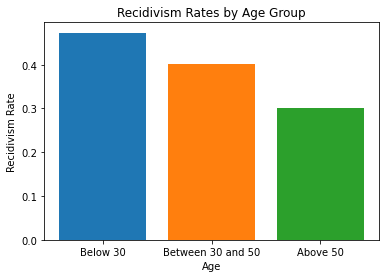

In [49]:
#Here we can see a steady decline in recidivism rates as the age at release increases. 
plt.bar(x = 'Below 30', height= below30_recid_rate)
plt.bar(x = 'Between 30 and 50', height = between_30_50_recid_rate)
plt.bar(x = 'Above 50', height = above_50_recid_rate)
plt.xlabel('Age')
plt.ylabel('Recidivism Rate')
plt.title('Recidivism Rates by Age Group');

#### Gender

In [51]:
male = ny_df[ny_df['Gender'] == 'MALE']
female = ny_df[ny_df['Gender'] == 'FEMALE']

In [57]:
#Males represent an overwhelming ~94% of the observations as such it may be difficult to draw accurate comparisons with only ~12k female observations v. 176k males. 
print(f'Count of Female Observations: {female.shape[0]}')
print(f'Count of Male Observations: {male.shape[0]}')
ny_df['Gender'].value_counts(normalize = True)

Count of Female Observations: 11842
Count of Male Observations: 176808


MALE      0.937228
FEMALE    0.062772
Name: Gender, dtype: float64

In [61]:
male.describe() 

,Release Year,Age at Release,recidivism,gender_map
count,176808.000000,176808.000000,176808.000000,176808.0
mean,2011.327734,35.376476,0.425145,1.0
std,2.286653,11.000085,0.494366,0.0
min,2008.000000,16.000000,0.000000,1.0
25%,2009.000000,26.000000,0.000000,1.0
50%,2011.000000,33.000000,0.000000,1.0
75%,2013.000000,44.000000,1.000000,1.0
max,2015.000000,100.000000,1.000000,1.0


In [62]:
female.describe()

,Release Year,Age at Release,recidivism,gender_map
count,11842.000000,11842.000000,11842.000000,11842.0
mean,2011.301132,36.920537,0.293700,0.0
std,2.326383,10.452333,0.455476,0.0
min,2008.000000,17.000000,0.000000,0.0
25%,2009.000000,28.000000,0.000000,0.0
50%,2011.000000,36.000000,0.000000,0.0
75%,2013.000000,45.000000,1.000000,0.0
max,2015.000000,86.000000,1.000000,0.0


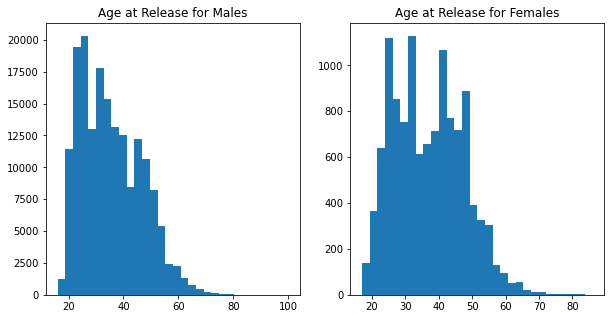

In [64]:
#The distrubtion of age at release is slightly lower for men as oppossed to women. Avg age at release for women is 37 versus 35 for men.
fig, ax = plt.subplots(1,2, figsize = (10,5))

ax[0].hist(male['Age at Release'], bins = 30)
ax[0].set_title('Age at Release for Males')
ax[1].hist(female['Age at Release'], bins = 30)
ax[1].set_title('Age at Release for Females');

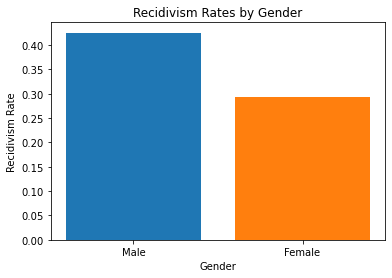

In [73]:
#Men have a 13% higher recidivism rate then women. 
plt.bar(x = 'Male', height= male[male['recidivism'] == 1]['recidivism'].value_counts() / male.shape[0])
plt.bar(x = 'Female', height = female[female['recidivism'] == 1]['recidivism'].value_counts() / female.shape[0])
plt.xlabel('Gender')
plt.ylabel('Recidivism Rate')
plt.title('Recidivism Rates by Gender');

#### County of Indictment

In [88]:
#There are 63 different counties of indictment however ~80% of observations come from 15 counties.
ny_df['County of Indictment'].value_counts(normalize = True)[:15]

NEW YORK       0.182067
KINGS          0.104394
BRONX          0.094355
QUEENS         0.070167
SUFFOLK        0.049632
MONROE         0.045460
ERIE           0.043615
ONONDAGA       0.033485
NASSAU         0.031625
ALBANY         0.031248
WESTCHESTER    0.023393
ORANGE         0.023096
ONEIDA         0.018669
BROOME         0.015823
SCHENECTADY    0.014583
Name: County of Indictment, dtype: float64

In [107]:
#Recidivism Rates by County of Indictment (showing the top 15 recidivism rates per county)
ny_df.groupby(['County of Indictment'])['recidivism'].mean().sort_values(ascending = False)[:15]

County of Indictment
MONROE         0.525770
ERIE           0.505105
SCHENECTADY    0.504907
CHEMUNG        0.501913
BROOME         0.497822
TOMPKINS       0.497630
CHAUTAUQUA     0.491356
TIOGA          0.485043
RENSSELAER     0.483302
CORTLAND       0.482866
ULSTER         0.482848
ONONDAGA       0.481716
SENECA         0.477663
ALBANY         0.475997
OSWEGO         0.474727
Name: recidivism, dtype: float64

### Modeling

Build and Tune a set of classification models based on gender, age and county of indictment
1. Logistic Regression
2. Random Forest
3. Ada Boost
4. Graident Boost
5. Stacked Model


#### Modeling Without County of Indictment

In [119]:
#Logistic Regression

X = ny_df[['gender_map', 'Age at Release']]
y = ny_df['recidivism']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [120]:
#Baseline 
y_train.value_counts(normalize = True)

0    0.583107
1    0.416893
Name: recidivism, dtype: float64

In [121]:
y_test.value_counts(normalize = True)

0    0.583105
1    0.416895
Name: recidivism, dtype: float64

In [122]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [123]:
log_train = lr.score(X_train, y_train)
log_test = lr.score(X_test, y_test)

In [124]:
#Random Forest
rf= RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.5870703729618557

In [125]:
rf_train = rf.score(X_train, y_train)
rf_test = rf.score(X_test, y_test)

In [126]:
rf_train

0.5883862121608345

In [127]:
rf_test

0.5870703729618557

In [128]:
#Ada Boost
ada= AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 42))
ada.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42))

In [129]:
ada_train = ada.score(X_train, y_train)
ada_test = ada.score(X_test, y_test)

In [130]:
ada_test

0.5870703729618557

In [131]:
#Gradient Boost
gboost= GradientBoostingClassifier(random_state = 42)
gboost.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [132]:
gb_train = gboost.score(X_train, y_train)
gb_test = gboost.score(X_test, y_test)

In [133]:
gb_test

0.5870703729618557

In [134]:
#Stacked Model
level1_estimators = [
    ('random_forest', RandomForestClassifier()),
    ('gboost', GradientBoostingClassifier()),
    ('ada', AdaBoostClassifier())
]

stacked_model = StackingClassifier(estimators=level1_estimators,
                                 final_estimator = LogisticRegression())

stacked_model.fit(X_train, y_train)

StackingClassifier(estimators=[('random_forest', RandomForestClassifier()),
                               ('gboost', GradientBoostingClassifier()),
                               ('ada', AdaBoostClassifier())],
                   final_estimator=LogisticRegression())

In [135]:
stack_train = stacked_model.score(X_train, y_train)
stack_test = stacked_model.score(X_test, y_test)

In [136]:
#KNN
ss = StandardScaler()
X_train_sc=ss.fit_transform(X_train)
X_test_sc= ss.transform(X_test)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [137]:
knn_train = knn.score(X_train, y_train)
knn_test = knn.score(X_test, y_test)

#### Rerun Models including County of Indictment

In [138]:
#Get Dummies on County
ny_df.head()

,Release Year,County of Indictment,Gender,Age at Release,Return Status,recidivism,gender_map
0,2008,UNKNOWN,MALE,55,Not Returned,0,1
1,2008,ALBANY,MALE,16,Returned Parole Violation,1,1
2,2008,ALBANY,MALE,17,Not Returned,0,1
3,2008,ALBANY,MALE,17,Returned Parole Violation,1,1
4,2008,ALBANY,MALE,18,Not Returned,0,1


In [139]:
#Creating a Dataframe including dummies of the county of indictment
df_dummies = pd.get_dummies(ny_df['County of Indictment'])
df_dummies['gender'] = ny_df['gender_map']
df_dummies['recidivism'] = ny_df['recidivism']
df_dummies['age'] = ny_df['Age at Release']

In [140]:
df_dummies.head()

,ALBANY,ALLEGANY,BRONX,BROOME,CATTARAUGUS,CAYUGA,CHAUTAUQUA,CHEMUNG,CHENANGO,CLINTON,...,UNKNOWN,WARREN,WASHINGTON,WAYNE,WESTCHESTER,WYOMING,YATES,gender,recidivism,age
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,55
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,16
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,17
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,17
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,18


In [141]:
#Define X and y with dummy data
X = df_dummies.drop(columns = ['recidivism'])
y = df_dummies['recidivism']

#Train test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state =42, stratify = y)

In [142]:
y_train2.value_counts(normalize = True)

0    0.583107
1    0.416893
Name: recidivism, dtype: float64

In [143]:
y_test2.value_counts(normalize = True)

0    0.583105
1    0.416895
Name: recidivism, dtype: float64

In [144]:
#Logistic Regression Model
lr2 = LogisticRegression()
lr2.fit(X_train2, y_train2)

C:\Users\dylan\anaconda3.1\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [145]:
log_train2 = lr2.score(X_train2, y_train2)
log_test2 = lr2.score(X_test2, y_test2)

In [146]:
#Random Forest with Hyperparameter tuning
rf2= RandomForestClassifier(random_state = 42)
rf_params = {
    'n_estimators': [120, 130],
    'max_depth': [15,20],
    'max_features' : [15,20],
    'n_jobs': [-1]
}

gs1 = GridSearchCV(rf, param_grid= rf_params, cv = 3, n_jobs = -1)

gs1.fit(X_train2, y_train2)
print(gs1.best_score_)
gs1.best_params_

0.5967968773263156


{'max_depth': 15, 'max_features': 20, 'n_estimators': 130, 'n_jobs': -1}

In [147]:
rf_train2 = gs1.score(X_train2, y_train2)
rf_test2 = gs1.score(X_test2, y_test2)

In [148]:
#Ada Boost with Hyperparam tuning
ada= AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 42))

ada_params= {
    'n_estimators': [50, 100],
    'base_estimator__max_depth':[1,3]
}

gs2 = GridSearchCV(ada, param_grid = ada_params, cv = 3, n_jobs = -1)
gs2.fit(X_train2, y_train2)
gs2.score(X_train2, y_train2)

0.5993624855993837

In [149]:
ada_train2 = gs2.score(X_train2, y_train2)
ada_test2 = gs2.score(X_test2, y_test2)

In [150]:
#Graident Boost
gboost2= GradientBoostingClassifier(random_state = 42)

gboost2.fit(X_train2, y_train2)

GradientBoostingClassifier(random_state=42)

In [151]:
gboost_train2 = gboost2.score(X_train2, y_train2)
gboost_test2 = gboost2.score(X_test2, y_test2)

In [152]:
#Stacked Model
level1_estimators = [
    ('random_forest', RandomForestClassifier()),
    ('gboost', GradientBoostingClassifier())
]

stacked_model2 = StackingClassifier(estimators=level1_estimators,
                                 final_estimator = LogisticRegression())

stacked_model2.fit(X_train2, y_train2)

StackingClassifier(estimators=[('random_forest', RandomForestClassifier()),
                               ('gboost', GradientBoostingClassifier())],
                   final_estimator=LogisticRegression())

In [153]:
stack_train2 = stacked_model2.score(X_train2, y_train2)
stack_test2 = stacked_model2.score(X_test2, y_test2)

In [154]:
#Model Evaluation No Dummies
train_scores = [log_train, rf_train, ada_train, gb_train, stack_train, knn_train]
eval_df = pd.DataFrame(train_scores, columns = ['train_scores'])

eval_df['test_scores'] = [log_test, rf_test, ada_test, gb_test, stack_test, knn_test]
eval_df.index = ['logreg', 'rf', 'ada', 'gb', 'stack', 'knn']
eval_df['diff'] = eval_df['train_scores'] - eval_df['test_scores']
eval_df['baseline'] = .58

eval_df

,train_scores,test_scores,diff,baseline
logreg,0.586831,0.587728,-0.000896,0.58
rf,0.588386,0.587070,0.001316,0.58
ada,0.588386,0.587070,0.001316,0.58
gb,0.588386,0.587070,0.001316,0.58
stack,0.588386,0.587070,0.001316,0.58
knn,0.534304,0.534614,-0.000310,0.58


In [155]:
#Model Evaluation With Dummies
train_scores2 = [log_train2, rf_train2, ada_train2, gboost_train2, stack_train2]
eval_df2 = pd.DataFrame(train_scores2, columns = ['train_scores'])

eval_df2['test_scores'] = [log_test2, rf_test2, ada_test2, gboost_test2, stack_test2]
eval_df2.index = ['logreg', 'rf', 'ada', 'gb', 'stack']
eval_df2['diff'] = eval_df2['train_scores'] - eval_df2['test_scores']
eval_df2['baseline'] = .58

eval_df2

,train_scores,test_scores,diff,baseline
logreg,0.598776,0.599262,-0.000486,0.58
rf,0.603236,0.597714,0.005521,0.58
ada,0.599362,0.599220,0.000143,0.58
gb,0.598988,0.598711,0.000277,0.58
stack,0.601087,0.600174,0.000913,0.58


### EDA Georgia
<br>1) Employment & Recidivism
<br>-Hypothesis: As percent days employed increases, recidivism should decrease
<br>-Is there a pivotal percent of days employed where we see a drop in recidivism?

<br>2) Potential Mitigators
<br>-Recidivism rates between people who did and did not have certain conditions of release

<br>3) Drug Use Deep Dive Looking at the impact of drug use on recidivism rates across THC, Cocaine, Meth
<br>-Some work already performed above but I need a better way to visualize these

<br>4) Gang Affiliation

<br>5)Supervision Risk score 
<br>-How accurate or innacurate is the risk score? 

<br>6) Demographics: Age, Gender, Race, Residence, Education

<br>7) Types of Crime Prior Offense, Years in Prison, Prior Arrest/Conviction Types

In [108]:
#EDA
georgia = pd.read_csv('./data/other/recidivism_full.csv')
georgia.head()

,ID,Gender,Race,Age_at_Release,Residence_PUMA,Gang_Affiliated,Supervision_Risk_Score_First,Supervision_Level_First,Education_Level,Dependents,...,DrugTests_Meth_Positive,DrugTests_Other_Positive,Percent_Days_Employed,Jobs_Per_Year,Employment_Exempt,Recidivism_Within_3years,Recidivism_Arrest_Year1,Recidivism_Arrest_Year2,Recidivism_Arrest_Year3,Training_Sample
0,1,M,BLACK,43-47,16,False,3.0,Standard,At least some college,3 or more,...,0.000000,0.0,0.488562,0.447610,False,False,False,False,False,1
1,2,M,BLACK,33-37,16,False,6.0,Specialized,Less than HS diploma,1,...,0.000000,0.0,0.425234,2.000000,False,True,False,False,True,1
2,3,M,BLACK,48 or older,24,False,7.0,High,At least some college,3 or more,...,0.166667,0.0,0.000000,0.000000,False,True,False,True,False,1
3,4,M,WHITE,38-42,16,False,7.0,High,Less than HS diploma,1,...,0.000000,0.0,1.000000,0.718996,False,False,False,False,False,1
4,5,M,WHITE,33-37,16,False,4.0,Specialized,Less than HS diploma,3 or more,...,0.058824,0.0,0.203562,0.929389,False,True,True,False,False,1


In [109]:
georgia.isnull().sum().sort_values(ascending = False).head(11)

Avg_Days_per_DrugTest           6103
DrugTests_Meth_Positive         5172
DrugTests_THC_Positive          5172
DrugTests_Cocaine_Positive      5172
DrugTests_Other_Positive        5172
Prison_Offense                  3277
Gang_Affiliated                 3167
Supervision_Level_First         1720
Jobs_Per_Year                    808
Supervision_Risk_Score_First     475
Percent_Days_Employed            462
dtype: int64

#### Drug Use - Meth, Cocaine, THC, Other

In [110]:
georgia['THC'] = georgia['DrugTests_THC_Positive']>0
georgia['Meth'] = georgia['DrugTests_Meth_Positive']>0
georgia['Cocaine'] = georgia['DrugTests_Cocaine_Positive']>0
georgia['Other_Drugs'] = georgia['DrugTests_Other_Positive']>0

georgia['THC'] = georgia['THC'].map({False: 0, True:1})
georgia['Meth'] = georgia['Meth'].map({False: 0, True:1})
georgia['Cocaine'] = georgia['Cocaine'].map({False: 0, True:1})
georgia['Other_Drugs'] = georgia['Other_Drugs'].map({False: 0, True:1})

In [111]:
georgia.groupby('Meth')['Recidivism_Within_3years'].value_counts(normalize = True)

Meth  Recidivism_Within_3years
0     True                        0.569502
      False                       0.430498
1     True                        0.663230
      False                       0.336770
Name: Recidivism_Within_3years, dtype: float64

In [112]:
georgia.groupby('THC')['Recidivism_Within_3years'].value_counts(normalize = True)

THC  Recidivism_Within_3years
0    True                        0.558987
     False                       0.441013
1    True                        0.629783
     False                       0.370217
Name: Recidivism_Within_3years, dtype: float64

In [113]:
georgia.groupby('Cocaine')['Recidivism_Within_3years'].value_counts(normalize = True)

Cocaine  Recidivism_Within_3years
0        True                        0.575679
         False                       0.424321
1        True                        0.592126
         False                       0.407874
Name: Recidivism_Within_3years, dtype: float64

In [114]:
georgia.groupby('Other_Drugs')['Recidivism_Within_3years'].value_counts(normalize = True)

Other_Drugs  Recidivism_Within_3years
0            True                        0.576751
             False                       0.423249
1            True                        0.579156
             False                       0.420844
Name: Recidivism_Within_3years, dtype: float64

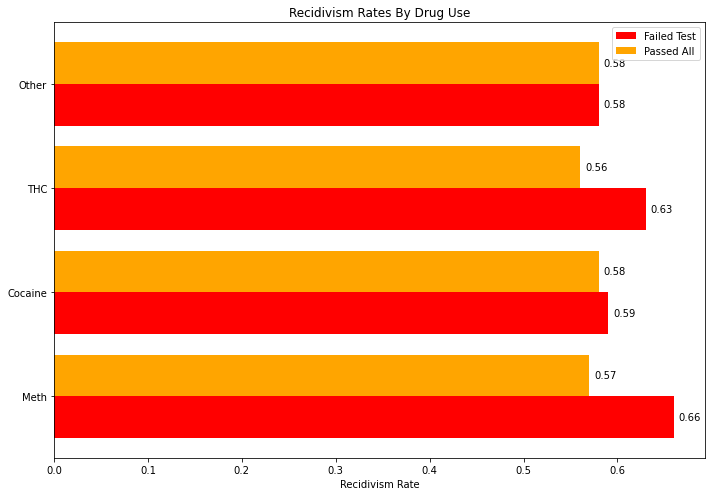

In [118]:
#Comparing Word Counts for Top 10 Republican Topics
labels = ['Meth', 'Cocaine', 'THC', 'Other']

positive = [.66, .59, .63, .58]
negative = [.57, .58, .56, .58]


x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots(figsize = (10, 7))

posbar = ax.barh(x - width/2, positive, width, label='Failed Test', color = 'Red')
negbar = ax.barh(x + width/2, negative, width, label='Passed All', color = 'Orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Recidivism Rate')
ax.set_title('Recidivism Rates By Drug Use')
ax.set_yticks(x, labels)
ax.legend()

ax.bar_label(negbar, padding=5)
ax.bar_label(posbar, padding=5)


fig.tight_layout()

plt.show()

In [ ]:
#It does seem odd to me that these 5k null drug tested folks have a higher recidivism rate. 
#I would have assumed there recidivism rate would have been inline with the folks who had negative drug tests
#Perhaps we shouldn't impute 0 for these folks but rather drop them as they might throw off the model?

georgia[georgia['DrugTests_Meth_Positive'].isnull() == True].groupby('Meth')['Recidivism_Within_3years'].value_counts(normalize = True)

In [ ]:
georgia[georgia['DrugTests_THC_Positive'].isnull() == True].groupby('THC')['Recidivism_Within_3years'].value_counts(normalize = True)

In [ ]:
georgia['target_var'] = georgia['Recidivism_Within_3years'].map({True:1, False:0})
georgia.head()

In [ ]:
georgia.corr()['target_var'].sort_values()

In [ ]:
#Highest Correlated Features (Percent Days Employed, Supervision Risk Score, Condition MH SA, PPViolations, Meth)

georgia.groupby('Percent_Days_Employed')['Recidivism_Within_3years'].value_counts(normalize = True)

In [ ]:
plt.scatter(georgia['target_var'], georgia['Percent_Days_Employed'])

In [ ]:
#How can I show how employment impacts recidivism?
#My hypothesis is that as percent days employed increases, recidivism decreases which we can see with -.24 correlation
#How can I better visualize this?

In [45]:
georgia.columns

Index(['ID', 'Gender', 'Race', 'Age_at_Release', 'Residence_PUMA',
       'Gang_Affiliated', 'Supervision_Risk_Score_First',
       'Supervision_Level_First', 'Education_Level', 'Dependents',
       'Prison_Offense', 'Prison_Years', 'Prior_Arrest_Episodes_Felony',
       'Prior_Arrest_Episodes_Misd', 'Prior_Arrest_Episodes_Violent',
       'Prior_Arrest_Episodes_Property', 'Prior_Arrest_Episodes_Drug',
       'Prior_Arrest_Episodes_PPViolationCharges',
       'Prior_Arrest_Episodes_DVCharges', 'Prior_Arrest_Episodes_GunCharges',
       'Prior_Conviction_Episodes_Felony', 'Prior_Conviction_Episodes_Misd',
       'Prior_Conviction_Episodes_Viol', 'Prior_Conviction_Episodes_Prop',
       'Prior_Conviction_Episodes_Drug',
       'Prior_Conviction_Episodes_PPViolationCharges',
       'Prior_Conviction_Episodes_DomesticViolenceCharges',
       'Prior_Conviction_Episodes_GunCharges', 'Prior_Revocations_Parole',
       'Prior_Revocations_Probation', 'Condition_MH_SA', 'Condition_Cog_Ed',
     